In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CHANNELS = 3
EPOCHS = 15


In [ ]:
from google.colab import drive
import tensorflow as tf

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Specify the path to your dataset
dataset_path = '/content/drive/MyDrive/bird_data/train'

# Define your image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create the image dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Mounted at /content/drive
Found 3208 files belonging to 20 classes.


In [ ]:
class_names = dataset.class_names
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

In [ ]:
len(dataset)

101

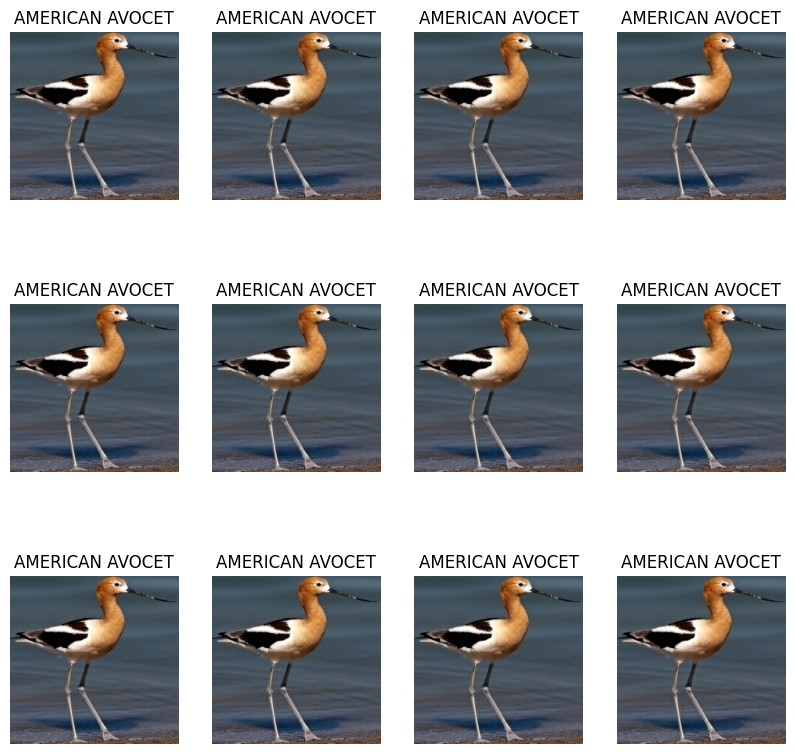

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")



In [ ]:
len(dataset)

101

In [ ]:
train_size = 0.8
len(dataset)*train_size

80.80000000000001

In [ ]:
train_ds = dataset.take(80)
len(train_ds)

80

In [ ]:
test_ds = dataset.skip(80)
len(test_ds)

21

In [ ]:
val_size = 0.1
len(dataset)*val_size

10.100000000000001

In [ ]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [ ]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

80

In [ ]:
len(val_ds)

10

In [ ]:
len(test_ds)

11

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.image.resize_with_pad(x, IMAGE_SIZE[0], IMAGE_SIZE[1])),
    layers.Lambda(lambda x: x * (1./255.0)),  # Rescale
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (1, IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)
n_classes = 20

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(20, activation='softmax'),
])

# No need to explicitly build the model in Colab

# Display model summary
model.build(input_shape=input_shape)






In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 conv2d_6 (Conv2D)           (1, 222, 222, 32)         896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (1, 111, 111, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (1, 109, 109, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (1, 54, 54, 64)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (1, 52, 52, 64)          

In [ ]:
from tensorflow.keras.utils import to_categorical

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
from tensorflow.keras.utils import to_categorical

# Assuming train_ds has elements in the form (images, labels)
train_labels = [label for _, label in train_ds]
val_labels = [label for _, label in val_ds]

# Flatten nested labels
train_labels_flat = [item for sublist in train_labels for item in sublist]
val_labels_flat = [item for sublist in val_labels for item in sublist]

# Update n_classes to the correct number of classes
n_classes = 20

In [39]:
train_labels_one_hot = to_categorical(train_labels_flat, num_classes=n_classes)
val_labels_one_hot = to_categorical(val_labels_flat, num_classes=n_classes)

In [41]:
print(f"Train labels shape: {train_labels_one_hot.shape}")
print(f"Validation labels shape: {val_labels_one_hot.shape}")

Train labels shape: (2536, 20)
Validation labels shape: (320, 20)


In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)       

In [43]:
# Assuming the model's output shape is (None, 20)
n_classes = 20

train_labels_one_hot = to_categorical(train_labels_flat, num_classes=n_classes)
val_labels_one_hot = to_categorical(val_labels_flat, num_classes=n_classes)

In [ ]:
model.output_shape

(1, 20)

In [47]:
print(f"Type of train_labels: {type(train_labels)}")
print(f"Type of val_labels: {type(val_labels)}")

Type of train_labels: <class 'list'>
Type of val_labels: <class 'list'>


In [ ]:
train_labels_one_hot.shape
val_labels_one_hot.shape

(320, 20)

In [ ]:
model.output_shape == train_labels_one_hot.shape
model.output_shape == val_labels_one_hot.shape

False

In [52]:
# Change the loss function to 'sparse_categorical_crossentropy'
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Remove the to_categorical calls
train_labels_one_hot = train_labels_flat
val_labels_one_hot = val_labels_flat

In [53]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
80/80 [==============================] - 173s 2s/step - loss: 2.9545 - accuracy: 0.0670 - val_loss: 2.7913 - val_accuracy: 0.1281
Epoch 2/15
80/80 [==============================] - 139s 2s/step - loss: 2.6243 - accuracy: 0.1636 - val_loss: 2.4233 - val_accuracy: 0.2719
Epoch 3/15
80/80 [==============================] - 143s 2s/step - loss: 2.2682 - accuracy: 0.2827 - val_loss: 2.1424 - val_accuracy: 0.3187
Epoch 4/15
80/80 [==============================] - 143s 2s/step - loss: 1.9530 - accuracy: 0.3742 - val_loss: 1.7439 - val_accuracy: 0.4406
Epoch 5/15
80/80 [==============================] - 143s 2s/step - loss: 1.7162 - accuracy: 0.4594 - val_loss: 1.5800 - val_accuracy: 0.5188
Epoch 6/15
80/80 [==============================] - 137s 2s/step - loss: 1.5094 - accuracy: 0.5185 - val_loss: 1.4566 - val_accuracy: 0.5219
Epoch 7/15
80/80 [==============================] - 138s 2s/step - loss: 1.3484 - accuracy: 0.5765 - val_loss: 1.1890 - val_accuracy: 0.6438
Epoch 8/15
80

In [54]:
score = model.evaluate(test_ds)


11/11 [==============================] - 14s 531ms/step - loss: 0.6761 - accuracy: 0.8267


In [56]:
score = model.evaluate(test_ds)
scores = score

print(scores)

11/11 [==============================] - 5s 475ms/step - loss: 0.6761 - accuracy: 0.8267
[0.6760591268539429, 0.8267045617103577]


In [57]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 80}

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
type(history.history['loss'])

list

In [60]:
len(history.history['loss'])

15

In [61]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.9544930458068848,
 2.624293088912964,
 2.2681639194488525,
 1.9529507160186768,
 1.7161686420440674]

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

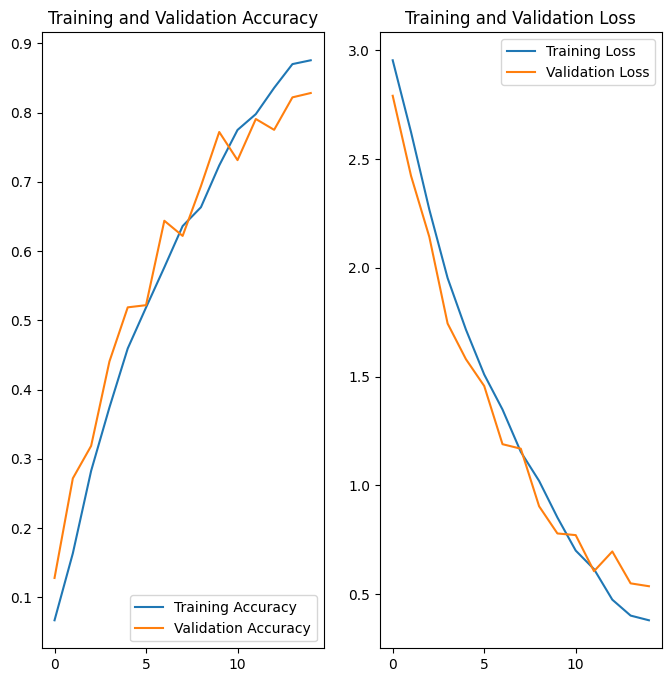

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: AMERICAN FLAMINGO
1/1 [==============================] - 1s 632ms/step
predicted label: AMERICAN FLAMINGO


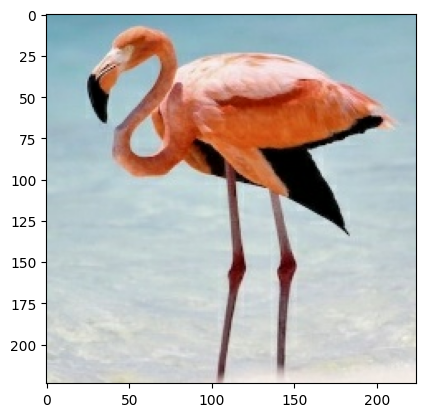

In [65]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [66]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    # Get the class name corresponding to the predicted index
    predicted_class = class_names[predicted_class_index]

    # Get the confidence (probability) for the predicted class
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


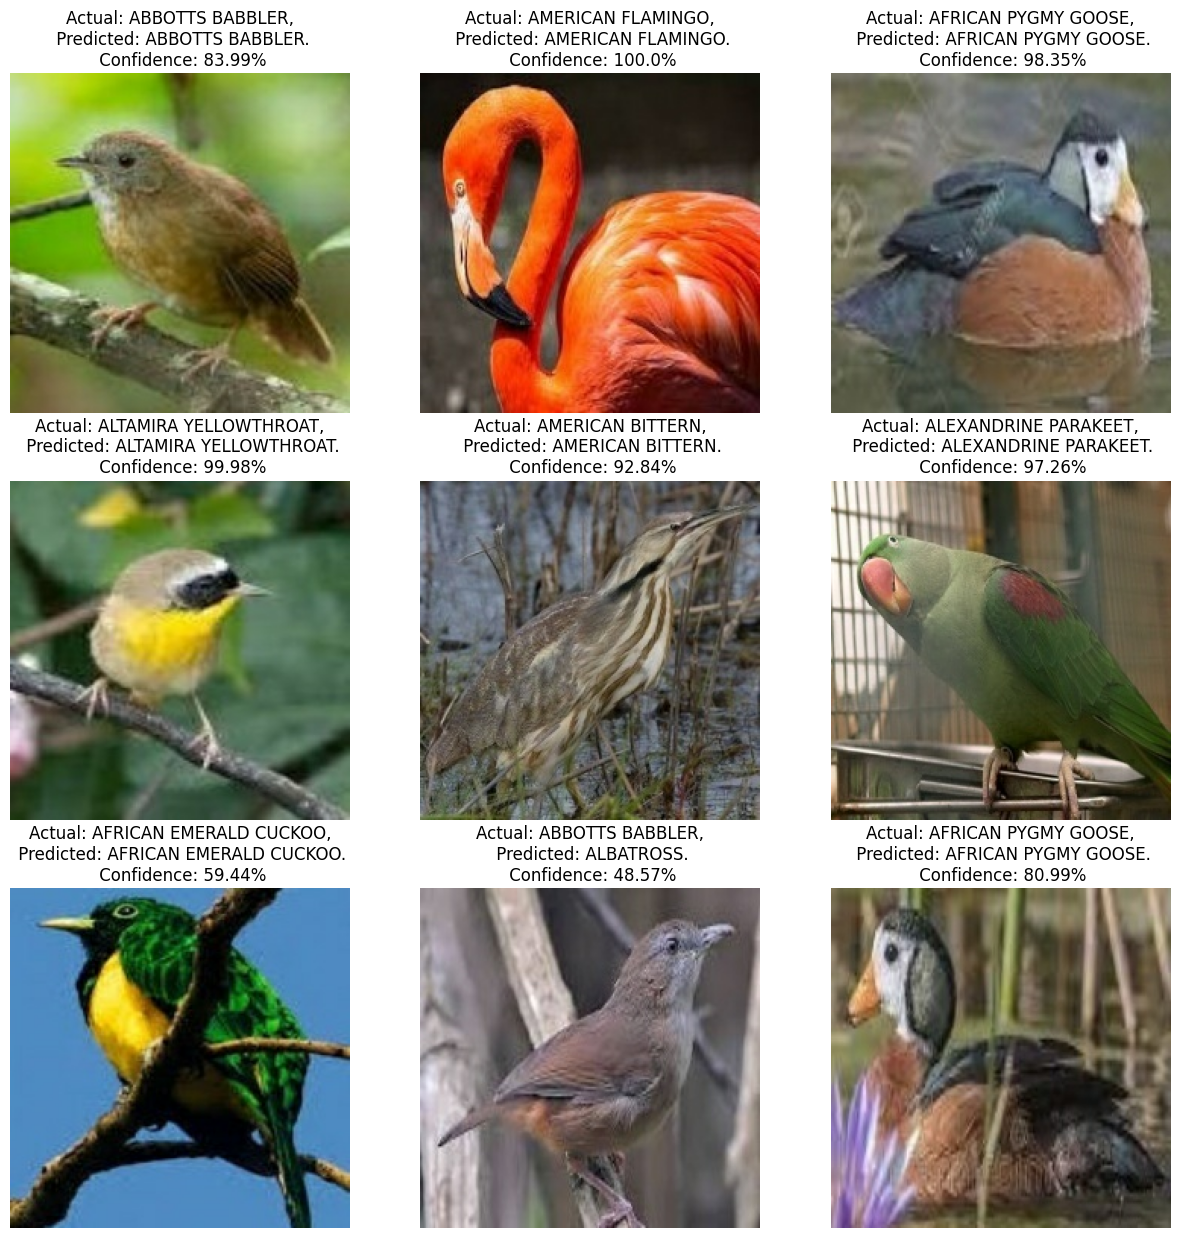

In [67]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 479ms/step


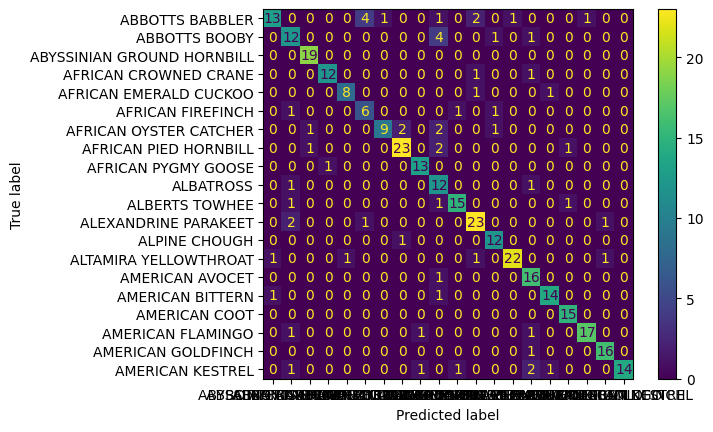

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the entire test dataset
all_predictions = []
all_actual_labels = []

for images, labels in test_ds:
    predictions = model.predict(images)
    all_predictions.extend(np.argmax(predictions, axis=1))
    all_actual_labels.extend(labels.numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predictions, labels=range(n_classes))

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d')
plt.show()


In [69]:
!ls ../


bin			    datalab  kaggle  libx32		       opt   sbin  tools
boot			    dev      lib     media		       proc  srv   usr
content			    etc      lib32   mnt		       root  sys   var
cuda-keyring_1.0-1_all.deb  home     lib64   NGC-DL-CONTAINER-LICENSE  run   tmp


In [72]:
!mkdir ../models

mkdir: cannot create directory ‘../models’: File exists


In [73]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [74]:
model.save("../bird.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
import os
print(os.getcwd())


/content


In [76]:
!mkdir /content/models
model_version = max([int(i) for i in os.listdir("/content/models/") + [0]]) + 1
model.save(f"/content/models/{model_version}.h5")
